### ***GRU model***
---

In [1]:
### import library
# import
from google.colab import drive
drive.mount("/content/drive")
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
# nlp
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('reuters')
from nltk.corpus import reuters
# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Sequential, Module
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...


In [93]:
### dataset import
# path="/content/drive/MyDrive/NEU_Group project/dataset/main_dataset.csv"
files=reuters.fileids()
print(f"Number of files: {len(files)}")
print(f"First 10 file IDs: {files[:10]}")
print("="*250)

# first file
file = files[0]
print(f"Words in '{file}':")
print(reuters.words(file))
print("="*250)

# categories
categories = reuters.categories()
print(f"Categories: {categories}")

Number of files: 10788
First 10 file IDs: ['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843']
Words in 'test/14826':
['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', ...]
Categories: ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'sh

In [94]:
### X, y
X=[]
y=[]

# clean
def clean_text(text):
    text=re.sub('[^a-zA-Z]',' ',text).lower()
    text=re.sub('\s+',' ',text).strip()
    return text

# add up
for fileid in reuters.fileids():
    document_words=reuters.words(fileid)
    document_text=' '.join(document_words)
    cleaned_text=clean_text(document_text)
    X.append(cleaned_text)

    # y
    document_categories=reuters.categories(fileid)
    y.append(document_categories[0])

# result
print(f"Total documents: {len(X)}")
print(f"Sample document: {X[0][:200]}...")
print(f"Category of sample document: {y[0]}")

Total documents: 10788
Sample document: asian exporters fear damage from u s japan rift mounting trade friction between the u s and japan has raised fears among many of asia s exporting nations that the row could inflict far reaching econom...
Category of sample document: trade


In [95]:
### vectorizer
from gensim.models import Word2Vec
model = Word2Vec([text.split() for text in X], vector_size=300, window=5, min_count=5, workers=4)
model.save("word2vec.model")

# get vector
def get_vector(word_list):
    word_vecs=[model.wv[word] for word in word_list if word in model.wv]
    if len(word_vecs)==0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vecs,axis=0)

X_series=pd.Series(X)
X_vectorized=X_series.apply(lambda doc: get_vector(doc.split()))
X=pd.DataFrame(list(X_vectorized))

In [100]:
### label encoding
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)

In [101]:
print("X shape:",X.shape)
print("y shape:",len(y))

X shape: (10788, 300)
y shape: 10788


In [102]:
### transform dataset to dataloader
# train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.23)

# to_tensor
train_data = torch.tensor(X_train.values, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.long)

# data_loader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_data = self.data[idx]
        sample_label = self.labels[idx]
        return sample_data, sample_label

# train
train_dataset=CustomDataset(train_data,train_labels)
train_data=DataLoader(dataset=train_dataset, batch_size=30, shuffle=True)

# test
test_dataset=CustomDataset(test_data,test_labels)
test_data=DataLoader(dataset=test_dataset,batch_size=30,shuffle=True)

# input_size check
data_sample, label_sample = next(iter(train_data))
input_size=data_sample.shape[1]
output_size=len(torch.unique(label_sample))

# labels
# unique_labels_count = y_train.nunique()
# print(f"Unique labels in y_train: {unique_labels_count}")

In [103]:
### input, label size check
# label counts
unique_labels_count = len(set(y))
# print(f"Unique labels count: {unique_labels_count}")

# print
print("X shape:",X.shape)
print(f"Unique labels count: {unique_labels_count}")

X shape: (10788, 300)
Unique labels count: 79


In [124]:
### build model (GRU)
class GRUcell(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(GRUcell, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size

        # update gate
        """
        get z_{t} to mediate degree of update candidate weights
        z_{t}=sigmoid(W_{z}*[h_{t-1},x_{t}])
        """
        self.weight_xz=nn.Parameter(torch.Tensor(hidden_size,input_size))
        self.weight_hz=nn.Parameter(torch.Tensor(hidden_size,hidden_size))
        self.bias_z=nn.Parameter(torch.Tensor(hidden_size))

        # reset gate
        """r_{t}=sigmoid(W_{r}*[h_{t-1},x_{t}])"""
        self.weight_xr=nn.Parameter(torch.Tensor(hidden_size,input_size)) # matrix
        self.weight_hr=nn.Parameter(torch.Tensor(hidden_size,hidden_size))
        self.bias_r=nn.Parameter(torch.Tensor(hidden_size)) # 1 dimension

        # candidate weights
        """h^{-}_{t}=tanh(W*[r_{t}*h_{t-1},x_{t}])"""
        self.weight_xn=nn.Parameter(torch.Tensor(hidden_size,input_size))
        self.weight_hn=nn.Parameter(torch.Tensor(hidden_size,hidden_size))
        self.bias_n=nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self,x,hidden):
        z=torch.sigmoid(x@self.weight_xz.t()+hidden@self.weight_hz.t()+self.bias_z)
        r=torch.sigmoid(x@self.weight_xr.t()+hidden@self.weight_hr.t()+self.bias_r)
        n=torch.tanh(x@self.weight_xn.t()+(r*hidden)@self.weight_hn.t()+self.bias_n)
        h_new=(1-z)*n+z*hidden

        return h_new

class GRUnetwork(nn.Module):
    def __init__(self,input_dims,hidden_dims,fan_out_dims,output_dims,dropout_rate=0.33):
        super(GRUnetwork,self).__init__()
        self.gru1 = GRUcell(input_dims, hidden_dims)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.gru2 = GRUcell(hidden_dims, hidden_dims)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dims, hidden_dims)
        self.act = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_dims, output_dims)


    def forward(self,x):
        hidden1 = torch.zeros(x.size(0), self.gru1.hidden_size)
        out1 = self.gru1(x, hidden1)
        out1 = self.dropout1(out1)

        hidden2 = torch.zeros(x.size(0), self.gru2.hidden_size)
        out2 = self.gru2(out1, hidden2)
        out2 = self.dropout2(out2)

        out = self.fc1(out2)
        out = self.act(out)
        out = self.fc2(out)
        return out

input_size = 300
hidden_dims = 64
fan_out_dims=32
output_dims = 80

model = GRUnetwork(input_size, hidden_dims, fan_out_dims, output_dims)
print(model)

GRUnetwork(
  (gru1): GRUcell()
  (dropout1): Dropout(p=0.33, inplace=False)
  (gru2): GRUcell()
  (dropout2): Dropout(p=0.33, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=64, out_features=80, bias=True)
)


In [125]:
### GRU train
import time
def train_model(model, train_loader, criterion, optimizer, epochs=101, test_every=10):
    train_losses, train_accs, times = [], [], []
    epoch_nums = []

    for epoch in range(epochs):
        epoch_start_time = time.time()

        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

        if epoch % test_every == 0:
            train_outputs = model(train_data.dataset.data.float())
            _, train_preds = torch.max(train_outputs, 1)
            train_accuracy = (train_preds == train_data.dataset.labels).float().mean()
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time

            epoch_nums.append(epoch)
            train_losses.append(loss.item())
            train_accs.append(train_accuracy)
            times.append(epoch_duration)

            print(f'Epoch {epoch}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}, Time: {epoch_duration:.2f} sec')

    return epoch_nums, train_losses, train_accs, times

# Define the model, criterion, and optimizer
model = GRUnetwork(input_size, hidden_dims, fan_out_dims, output_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# Train the model
epoch_nums, train_losses, train_accs, times = train_model(model, train_data, criterion, optimizer)

Epoch 0, Loss: 1.69, Train Accuracy: 0.67, Time: 1.37 sec
Epoch 10, Loss: 1.37, Train Accuracy: 0.71, Time: 3.78 sec
Epoch 20, Loss: 0.71, Train Accuracy: 0.73, Time: 3.30 sec
Epoch 30, Loss: 1.17, Train Accuracy: 0.72, Time: 3.14 sec
Epoch 40, Loss: 1.90, Train Accuracy: 0.71, Time: 3.99 sec
Epoch 50, Loss: 0.86, Train Accuracy: 0.73, Time: 3.02 sec
Epoch 60, Loss: 1.08, Train Accuracy: 0.74, Time: 3.17 sec
Epoch 70, Loss: 1.44, Train Accuracy: 0.72, Time: 3.76 sec
Epoch 80, Loss: 1.43, Train Accuracy: 0.70, Time: 3.13 sec
Epoch 90, Loss: 0.58, Train Accuracy: 0.73, Time: 3.05 sec
Epoch 100, Loss: 1.03, Train Accuracy: 0.74, Time: 3.85 sec


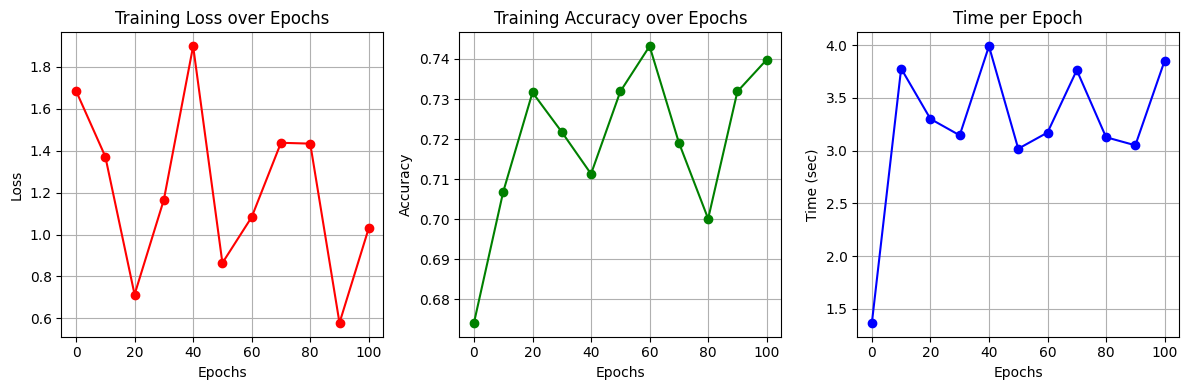

In [130]:
### GRU plots
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epoch_nums, train_losses, marker='o', color='r')
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epoch_nums, train_accs, marker='o', color='g')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)

# time
plt.subplot(1, 3, 3)
plt.plot(epoch_nums, times, marker='o', color='b')
plt.title("Time per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Time (sec)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [137]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)

        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

input_dim = 300
hidden_dim = 64
output_dim = 80
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

In [138]:
### LSTM train
def train_model(model, train_loader, criterion, optimizer, epochs=101, test_every=10):
    train_losses, train_accs, times = [], [], []
    epoch_nums = []

    for epoch in range(epochs):
        epoch_start_time = time.time()

        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

        if epoch % test_every == 0:
            train_outputs = model(train_data.dataset.data.float())
            _, train_preds = torch.max(train_outputs, 1)
            train_accuracy = (train_preds == train_data.dataset.labels).float().mean()
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time

            epoch_nums.append(epoch)
            train_losses.append(loss.item())
            train_accs.append(train_accuracy)
            times.append(epoch_duration)

            print(f'Epoch {epoch}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}, Time: {epoch_duration:.2f} sec')

    return epoch_nums, train_losses, train_accs, times

# Define the model, criterion, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# Train the model
epoch_nums, train_losses, train_accs, times = train_model(model, train_data, criterion, optimizer)

Epoch 0, Loss: 0.96, Train Accuracy: 0.72, Time: 1.55 sec
Epoch 10, Loss: 0.51, Train Accuracy: 0.78, Time: 3.84 sec
Epoch 20, Loss: 0.83, Train Accuracy: 0.78, Time: 4.14 sec
Epoch 30, Loss: 0.65, Train Accuracy: 0.77, Time: 3.82 sec
Epoch 40, Loss: 0.57, Train Accuracy: 0.76, Time: 3.67 sec
Epoch 50, Loss: 0.96, Train Accuracy: 0.79, Time: 3.71 sec
Epoch 60, Loss: 1.09, Train Accuracy: 0.78, Time: 3.56 sec
Epoch 70, Loss: 0.70, Train Accuracy: 0.79, Time: 3.48 sec
Epoch 80, Loss: 0.22, Train Accuracy: 0.80, Time: 3.54 sec
Epoch 90, Loss: 0.82, Train Accuracy: 0.79, Time: 3.67 sec
Epoch 100, Loss: 0.94, Train Accuracy: 0.79, Time: 3.44 sec


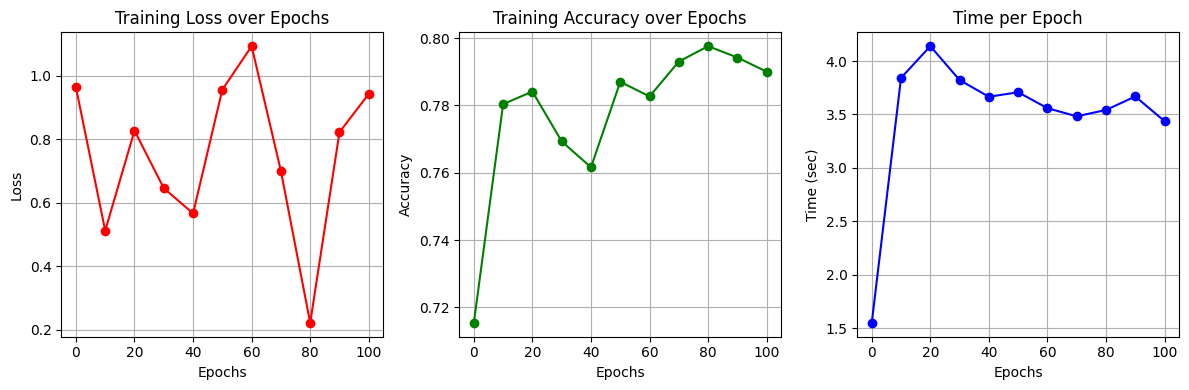

In [139]:
### LSTM plots
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epoch_nums, train_losses, marker='o', color='r')
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epoch_nums, train_accs, marker='o', color='g')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)

# time
plt.subplot(1, 3, 3)
plt.plot(epoch_nums, times, marker='o', color='b')
plt.title("Time per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Time (sec)")
plt.grid(True)

plt.tight_layout()
plt.show()